In [1]:
#Заглушка, задание выгружу в выходные 29-30.10
#Спасибо за понимание!

179769313486231590772930519078902473361797697894230657273430081157732675805500963132708477322407536021120113879871393357658789768814416622492847430639474124377767893424865485276302219601246094119453082952085005768838150682342462881473913110540827237163350510684586298239947245938479716304835356329624224137216

# Task 2 Закрепление Линейной Регрессии 
#  (Продвинутый канал)

**Задание:**

1. Ознакомьтесь с содержанием демонстрационных блокнотов (Неделя 3 и аналог для синтетических данных) 

2. Создайте новый блокнот, импортируйте необходимые библиотеки (не обязательно копировать все - только нужные функции и /или классы)

3.  Для синтетических данных 

3.1 Сгенерируйте различные линейные, полиномиальные и другие зависимости отличные от тех, что в примере(как минимум 3 поднабора)

3.2 Проверьте как с этими наборами справятся полиномы различной степени и разные типы регуляризации

4. Скачайте набор данных Cars Moldova (можно сразу очищенных от дубликатов и выбросов, лучше с добавленными признаками из "Закрепления Исследовательского анализа")  

4.1 Используйте любую из подготовленных вами моделей линейной регрессии для предсказания цены автомобилей на вторичном рынке Молдавии. Оцените модель на отложенной выборке  
4.2 Оцените влияние разных типов предварительной обработки на результат  
4.3 Сравните результаты модели при использовании только числовых признаков и при добавлении категориальных признаков с помощью one-hot кодирования  
4.4 Оцените наиболее значимые признаки для модели проанализировав веса  

5. Загрузите ссылку (предварительно убедившись в открытом доступе) или ipynb файл своего решения в MS Teams 

Блокнот необходимо прилежно оформить  

хочется видеть структуру (Заголовки разного уровня);  
ожидается видеть не только код, но и комментарии к нему;  
не должно быть запущенных ячеек с ошибками; 
ожидается что рисунки адекватно оформлены (не маленького размера, есть описание того, что на рисунке)

In [2]:
"-"*50

'--------------------------------------------------'

### Загрузка библиотек

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### 3.1 Сгенерируйте различные линейные, полиномиальные и другие зависимости отличные от тех, что в примере(как минимум 3 поднабора)

**Генерация Данных**

In [4]:
def true_fun(x, a=np.exp(2), b = 0.5, f=np.tan):
    x = np.atleast_1d(x)[:]
    a = np.atleast_1d(a)
    
    if f is None: f = lambda x:x # line
    x = np.sum([ai*np.power(x, i+1) for i,ai in enumerate(a)],axis=0)

    return f(x+ b)

def noises(shape , noise_power):
    return np.random.randn(*shape) *noise_power

def dataset(a, b, f = None,  N = 250, x_max =1, noise_power = 0, random_x = True,  seed = 42):
    np.random.seed(seed)
    
    if random_x:
        x = np.sort(np.random.rand(N))*x_max    
    else:
        x = np.linspace(0,x_max,N)
    
    y_true = np.array([])
    
    for f_ in np.append([], f):
        y_true=np.append(y_true, true_fun(x, a, b, f_))
    
    y_true = y_true.reshape(-1,N).T
    y = y_true + noises(y_true.shape , noise_power)

    return y, y_true, np.atleast_2d(x).T

In [5]:
def vis_data(y, y_true,x, title):
    fig  = plt.figure(figsize=(15,10))
    plt.scatter(x[:,0], y, edgecolor='b', label="Зашумленные Данные",s=196, alpha = 0.6)
    plt.scatter(x[:,0], y_true,label="Реальные Данные", s=81,c='g', alpha = 0.8)
    plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35)
    plt.legend(fontsize=25)
    plt.title(title, fontsize=25 )
    plt.xticks(FontSize = 25)
    plt.yticks(FontSize = 25);
    plt.tight_layout()

<ipython-input-5-d99cf6dd878c>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(FontSize = 25)
<ipython-input-5-d99cf6dd878c>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.yticks(FontSize = 25);


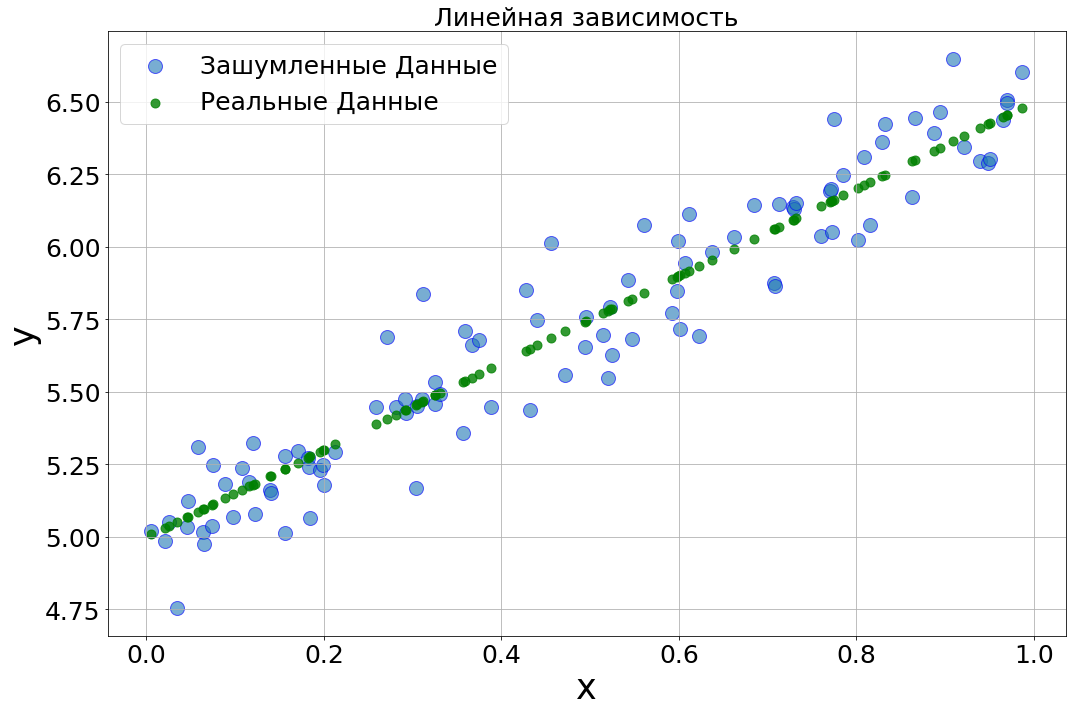

In [6]:
noise_power = 0.15

y, y_true, x = dataset(a = 1.5, b = 5,
                       f = None,  N = 100,
                       x_max =1, 
                       noise_power = noise_power,
                       seed = 42)
vis_data(y, y_true,x, 'Линейная зависимость')

In [7]:
def train_test_split(x,y, train_size=None, test_size=None, random_state=42, shuffle=True,):
    if random_state: np.random.seed(random_state)
    
    size = y.shape[0]
    idxs = np.arange(size)
    if shuffle: np.random.shuffle(idxs)
    
    if test_size and train_size is None:
        if (test_size<= 1):  train_size = 1 - test_size
        else:  train_size = size - test_size
        test_size = None    
        
    if train_size is None or train_size > size: train_size = size
        
    if (train_size<= 1): train_size *= size
        
    if test_size is not None: 
        if test_size<= 1: test_size *= size    
        if test_size>size: test_size = size-train_size
    else: test_size = 0

    x_train, y_train = x[idxs[:int(train_size)]], y[idxs[:int(train_size)]]
    x_val,   y_val   = x[idxs[int(train_size):size - int(test_size)]], y[idxs[int(train_size):size - int(test_size)]]
    
    if test_size > 0:
        x_test, y_test = x[idxs[size - int(test_size):]], y[idxs[size - int(test_size):]]
        return x_train, y_train.squeeze(), x_val, y_val.squeeze(), x_test, y_test.squeeze() 
    return x_train, y_train.squeeze(), x_val, y_val.squeeze()


x_train, y_train, x_val, y_val, x_test, y_test = train_test_split(x, y, train_size = 0.5, test_size=0.3, )    
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape,  x_test.shape, y_test.shape )

    
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )    
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )



(50, 1) (50,) (20, 1) (20,) (30, 1) (30,)
(70, 1) (70,) (30, 1) (30,)


In [8]:
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )    
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )


(70, 1) (70,) (30, 1) (30,)


In [9]:
def init_weights(W_shape, add_bias = True, random_state = 42):
    W_shape = np.atleast_1d(W_shape)
    if random_state: 
        np.random.seed(random_state)
    W = np.random.randn(*list(W_shape))/np.sqrt(np.sum(W_shape))    
    if add_bias: 
        W = np.column_stack((np.zeros(W.shape[-1]),W ))
    return W.squeeze()

In [10]:
def predict( X, W, add_bias = True):
    if add_bias:
        X_full = np.column_stack((np.ones(X.shape[0]),X))
    else:
        X_full = X
    return  np.dot(X_full,W)

def loss_func(yhat, y):
    return np.square(yhat - y)  

In [11]:
x_train[:1]

array([[0.80839735]])

In [12]:
weights = init_weights(x.shape[1])
yhat = predict( x_train[0],weights)
loss = loss_func(yhat, y[0])

print(f'{weights}')
print(f'predict {yhat},\nground truth {y[0]},\nloss: {loss}')

[0.         0.49671415]
predict [0.4015424],
ground truth [5.02134024],
loss: [21.34253201]


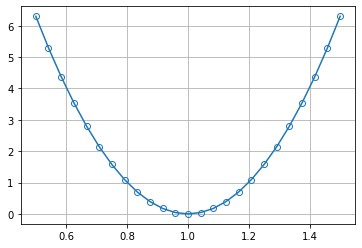

In [13]:
decline = np.linspace(start = 0.5, stop = 1.5,num = 25)
yhat = decline* y[0]
loss = loss_func(yhat, y[0])
plt.plot(decline,loss,'-o', mfc = 'none'); plt.grid(); 

In [14]:
def fit(X, y, learning_rate, weights = None,  epochs=30):

    if weights is None: weights = init_weights(X.shape[1])
    cost    = np.zeros(epochs)

    for i in range(epochs): 
        yhat    = predict(X,weights)
        grad    = grad_loss(yhat,  y, X) 
        weights = update_weights(grad, weights, lerning_rate)  
        cost[i] = loss_func(yhat,  y).mean()
                
    return weights, cost

In [15]:
def plot_model_weights(x_train, y_train, x_test, x, y, weights):
    plt.plot(x_train[:,0], predict(x_train,weights, ),
            '.', label='Предсказание на x_train',
            markersize = 15)
    plt.plot(x_test[:,0], predict(x_test,weights, ),
            'o', label='Предсказание на x_test',
            markersize = 15, alpha =0.8)
    plt.plot(x_train[:,0], y_train, '.',
            label="Тренировочные данные", linewidth=2,c='r')
    plt.plot(x[:,0], y, '--',
            label="Истинные Значения", linewidth=4,c='g')
    plt.legend(fontsize=20); plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35);
    plt.xticks(FontSize = 25)
    plt.yticks(FontSize = 25);

<ipython-input-15-a33491cfb7e3>:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(FontSize = 25)
<ipython-input-15-a33491cfb7e3>:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.yticks(FontSize = 25);


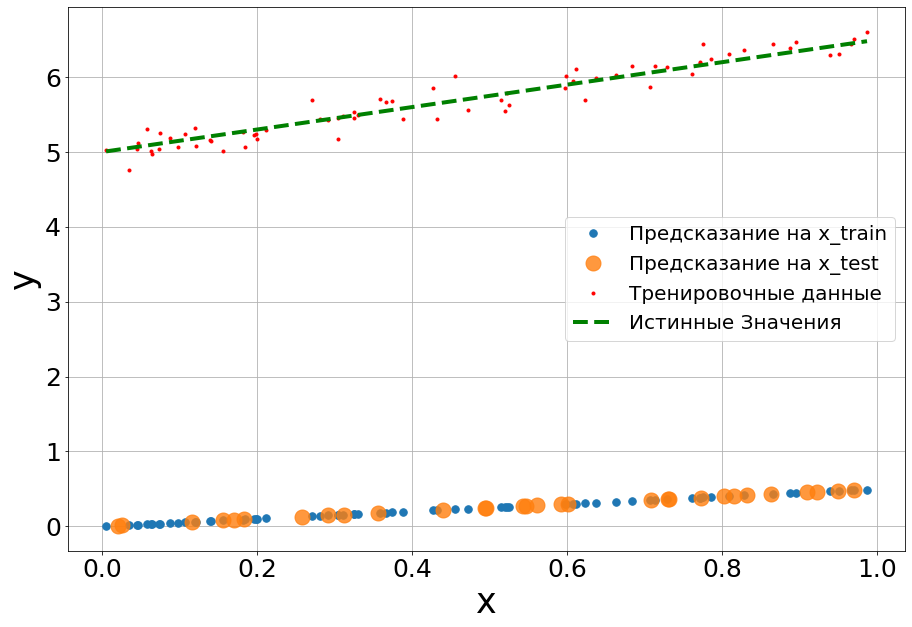

In [16]:
fig  = plt.figure(figsize=(15,10))

plot_model_weights(x_train, y_train, x_test, x, y_true, weights)